<a href="https://colab.research.google.com/github/albalcar/Concurso-de-Modelizaci-n/blob/main/1_1_Feature_engineering_Llamas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#En primer lugar, comencemos instalando algunas bibliotecas que pueden ser de utilidad:
#-accelerate: permite usar múltiples GPU's/CPU's en paralelo.
#- bitsandbytes: permite que los modelos funcionen con información comprimida (lo que ahorra espacio y tiempo), pero que puedan
#realizar cálculos más precisos cuando sea necesrio.
#-transformer: biblioteca para procesamiento de NPL.
!pip install -q -U accelerate==0.23.0 bitsandbytes==0.41.1 transformers==4.31

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.5 MB/s eta 0:00:00


In [2]:
import os
#PyTorch utilizará la primera GPU disponible
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#Establecemos que el proceso de tokenización no se lleve en paralelo
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#Evitamos avisos innecesarios
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Importamos la función "tqdm" de la biblioteca "tqdm", útil para las estimaciones de tiempo de procesos
from tqdm import tqdm

# Importamos la biblioteca "bitsandbytes" y usamos el alias "bnb"
import bitsandbytes as bnb

# Importamos la biblioteca "torch" que se usará para establecer el tipo de dato de cálculo de precisión del modelo
import torch

# Importamos la biblioteca "transformers" de Hugging Face, útil para trabajar con modelos NLP
import transformers


# Importamos clases y configuraciones adicionales de la biblioteca "transformers" de Hugging Face.
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
    logging
)


In [6]:
#Cargamos los datos
from google.colab import files
uploaded = files.upload()

Saving Restaurant reviews.csv to Restaurant reviews.csv


In [7]:
#Vemos que se han cargado correctamente
df = pd.read_csv('Restaurant reviews.csv')
df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [ ]:
#Creamos una función para establecer el prompt y la aplicamos a la columna 'Review' de nuestros datos:
def generate_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets,
            determine if it is positive, neutral, or negative, and return the answer as
            the corresponding sentiment label "positive" or "neutral" or "negative".

            [{data_point["Review"]}] = """.strip()

X_eval= pd.DataFrame(df.apply(generate_prompt, axis=1),
                       columns=["Review"])
X_eval

,Review
0,Analyze the sentiment of the news headline enc...
1,Analyze the sentiment of the news headline enc...
2,Analyze the sentiment of the news headline enc...
3,Analyze the sentiment of the news headline enc...
4,Analyze the sentiment of the news headline enc...
...,...
9995,Analyze the sentiment of the news headline enc...
9996,Analyze the sentiment of the news headline enc...
9997,Analyze the sentiment of the news headline enc...
9998,Analyze the sentiment of the news headline enc...


In [ ]:
#Iniciamos sesión en Hugging Face para acceder al modelo:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cr

In [ ]:
# Definimos el nombre del modelo preentrenado que se utilizará
model_name = "meta-llama/Llama-2-7b-chat-hf"

# Configuramos el tipo de dato de cálculo para bitsandbytes (en este caso, se usa "float16")
compute_dtype = getattr(torch, "float16")

# Configuración para bitsandbytes:
#Buscamos un equilibrio entre precisión y eficiencia en memoria y tiempo de computación
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,             # Cargamos datos en precisión de 4 bits
    bnb_4bit_quant_type="nf4",     # Tipo de cuantización para datos en precisión de 4 bits
    bnb_4bit_compute_dtype=compute_dtype,  # Tipo de dato de cálculo para datos en precisión de 4 bits
    bnb_4bit_use_double_quant=False,       # No usamos cuantización doble para datos en precisión de 4 bits
)

# Cargamos el modelo preentrenado con bitsandbytes habilitado
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
)

# Desactivamos el uso de caché en la configuración del modelo
model.config.use_cache = False

# Configuramos la tasa de aprendizaje preentrenada
model.config.pretraining_tp = 1

# Cargamos el tokenizador del modelo preentrenado
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
)

# Establecemos el token de relleno igual al token de fin de secuencia (eos_token)
tokenizer.pad_token = tokenizer.eos_token

# Configuramos el lado de relleno a la derecha
tokenizer.padding_side = "right"


(…)ma-2-7b-chat-hf/resolve/main/config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

(…)esolve/main/model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

(…)t-hf/resolve/main/generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

(…)at-hf/resolve/main/tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

(…)2-7b-chat-hf/resolve/main/tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

(…)-hf/resolve/main/special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
# Definimos la función "predict" que realizará predicciones de sentimiento:
def predict(X_eval, model, tokenizer):
    # Inicializamos una lista para almacenar las predicciones de sentimiento
    y_pred = []

    # Iteramos a través de las filas del conjunto de datos de entrada
    for i in tqdm(range(len(X_eval))):
        # Obtenemos el texto de revisión de la fila actual
        prompt = X_eval.iloc[i]["Review"]

        # Creamos un pipeline para la generación de texto
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens=1,
                        temperature=0.0,
                       )

        # Generamos el texto
        result = pipe(prompt)

        # Extraemos la parte final de la generación que contiene la predicción de sentimiento
        answer = result[0]['generated_text'].split("=")[-1]

        # Determinamos el sentimiento y agregamos a la lista de predicciones
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")

    # Creamos un DataFrame con las predicciones de sentimiento
    y_pred_df = pd.DataFrame(y_pred, columns=['Sentimiento'])

    # La función devuelve el DataFrame con las predicciones
    return y_pred_df

In [ ]:
prediccion=predict(X_eval,model,tokenizer)

  0%|          | 0/10000 [00:00<?, ?it/s]Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
100%|██████████| 10000/10000 [48:40<00:00,  3.42it/s]


In [ ]:
prediccion

,Sentimiento
0,positive
1,positive
2,positive
3,positive
4,positive
...,...
9995,none
9996,positive
9997,none
9998,positive


In [5]:
#Vamos a analizar como clasifica LLamas:
#Primero, vamos a contar cuantas etiquetas hemos obtenido de cada tipo
conteo = prediccion['Sentimiento'].value_counts()
conteo

positive    6125
negative    3362
none         453
neutral       60
Name: Sentimiento, dtype: int64

In [8]:
#Contamos ahora cuantas reseñas hay de cada puntuacióne el dataframe original
conteo_df = df['Rating'].value_counts()
conteo_df

5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

In [9]:
#La mayoría de las reseñas son de 4-5 estrellas.
#La mayoría de las reseñas clasificadas por el modelo LLM son positivas.
#LLM no consigue captar bien los sentimientos de algunas reseñas, devolviendo 'None'.
#Parece que el LLM no capta bien las observaciones neutrales.

In [10]:
#Vamos a crear un dataframe que emplearemos para entrenar el modelo de predicción y que nos ayudará a ver un poco más en
#profundidad como clasifica el LLM
# Seleccionamos las columnas que utilizaremos en el modelo.
nuevas_columnas = ['Review', 'Rating', 'Metadata']

# Eliminamos el resto de columnas del dataset.
reviews = df[nuevas_columnas]

# Extraemos el número de Reviews y Followers de la columna Metadata en dos nuevas columnas.
# El razonamiento detrás de esta transformación se encuentra en el notebook '1.0.1 Análisis Metadata'.
reviews[['Reviews', 'Followers']] = reviews['Metadata'].str.extract('(\d+)\D*(\d*)', expand=True)
reviews[['Reviews', 'Followers']] = reviews[['Reviews', 'Followers']].apply(pd.to_numeric)
#Decidimos imputar por 0's los valores nulos de 'Reviews' y 'Followers'
reviews['Reviews'].fillna(0, inplace=True)
reviews['Followers'].fillna(0, inplace=True)
reviews = reviews.drop('Metadata', axis=1)



In [11]:
#Eliminamos la columna 'Review', pues ya hemos obtenido el sentimiento previamente y concatenamos con el dataframe en el que guardamos
#los sentimientos obtenidos
reviews = reviews.drop('Review', axis=1)
data_LLM=pd.concat([prediccion, reviews], axis=1)
data_LLM

,Sentimiento,Rating,Reviews,Followers
0,positive,5,1.0,2.0
1,positive,5,3.0,2.0
2,positive,5,2.0,3.0
3,positive,5,1.0,1.0
4,positive,5,3.0,2.0
...,...,...,...,...
9995,none,3,53.0,54.0
9996,positive,4.5,2.0,53.0
9997,none,1.5,65.0,423.0
9998,positive,4,13.0,144.0


In [12]:
#Eliminamos el valor de 'Rating' tipo str:
data_LLM = data_LLM[data_LLM['Rating'] != 'Like']
#Convertimos la columna 'Rating' a numérico
data_LLM['Rating'] = pd.to_numeric(data_LLM['Rating'])

In [13]:
#Vemos que se ha aplicado
data_LLM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sentimiento  9999 non-null   object 
 1   Rating       9961 non-null   float64
 2   Reviews      9999 non-null   float64
 3   Followers    9999 non-null   float64
dtypes: float64(3), object(1)
memory usage: 390.6+ KB


In [14]:
#Vamos a estudiar los datos nulos restantes:
#Primero, vamos a identificar los valores 'none' de la columna sentimientos como nulos:
data_LLM['Sentimiento'] = data_LLM['Sentimiento'].replace('none', np.nan)
data_LLM.isna().sum()

Sentimiento    453
Rating          38
Reviews          0
Followers        0
dtype: int64

In [15]:
#Eliminamos los valores nulos
data_LLM=data_LLM.dropna()
#Vemos que se ha efectuado la transformación
data_LLM.isna().sum()


Sentimiento    0
Rating         0
Reviews        0
Followers      0
dtype: int64

In [16]:
#Vamos a estudiar un poco más sobre como clasifica el modelo LLM. Esperamos que las reseñas entre 4-5 estrellas hayan sido clasificadas como
#mayormente positivas, entre 3-4 estrellas como neutrales o positivas, entre 2-3 mayormente negativas aunque podrían esperarse neutrales y entre 1-2 como
#mayormente negativas

filtro_4_5 = (data_LLM['Rating'] >= 4) & (data_LLM['Rating'] <= 5)
#Las contamos
reseñas_4_5 = (filtro_4_5).sum()
print(reseñas_4_5)
print()
#Filtramos cuantas reseñas entre 4 y 5 estrellas clasifican los modelos como positivas-negativas-neutrales
resultados_llamas_4_5=data_LLM.loc[filtro_4_5, ['Sentimiento']]
print(resultados_llamas_4_5['Sentimiento'].value_counts())
print()

#Filtramos las reseñas con estrellas entre 3 (incluido) y 4 (no incluido)
filtro_3_4 = (data_LLM['Rating'] >= 3) & (data_LLM['Rating'] < 4)
#Las contamos
reseñas_3_4 = (filtro_3_4).sum()
print(reseñas_3_4)
print()
#Filtramos cuantas reseñas entre 3 y 4 estrellas clasifican los modelos como positivas-negativas-neutrales
resultados_llamas_3_4=data_LLM.loc[filtro_3_4, ['Sentimiento']]
print(resultados_llamas_3_4['Sentimiento'].value_counts())
print()

#Filtramos las reseñas con estrellas entre 2 (incluido) y 3 (no incluido)
filtro_2_3 = (data_LLM['Rating'] >= 2) & (data_LLM['Rating'] < 3)
#Las contamos
reseñas_2_3 = (filtro_2_3).sum()
print(reseñas_3_4)
print()
#Filtramos cuantas reseñas entre 3 y 4 estrellas clasifican los modelos como positivas-negativas-neutrales
resultados_llamas_2_3=data_LLM.loc[filtro_2_3, ['Sentimiento']]
print(resultados_llamas_2_3['Sentimiento'].value_counts())
print()

#Filtramos las reseñas con estrellas entre 1 (incluido) y 2 (no incluido)
filtro_1_2 = (data_LLM['Rating'] >= 1) & (data_LLM['Rating'] < 2)
#Las contamos
reseñas_1_2 = (filtro_1_2).sum()
print(reseñas_1_2)
print()
#Filtramos cuantas reseñas entre 3 y 4 estrellas clasifican los modelos como positivas-negativas-neutrales
resultados_llamas_1_2=data_LLM.loc[filtro_1_2, ['Sentimiento']]
print(resultados_llamas_1_2['Sentimiento'].value_counts())
print()

5976

positive    5664
negative     281
neutral       31
Name: Sentimiento, dtype: int64

1140

negative    709
positive    406
neutral      25
Name: Sentimiento, dtype: int64

1140

negative    647
positive     28
neutral       4
Name: Sentimiento, dtype: int64

1713

negative    1687
positive      26
Name: Sentimiento, dtype: int64



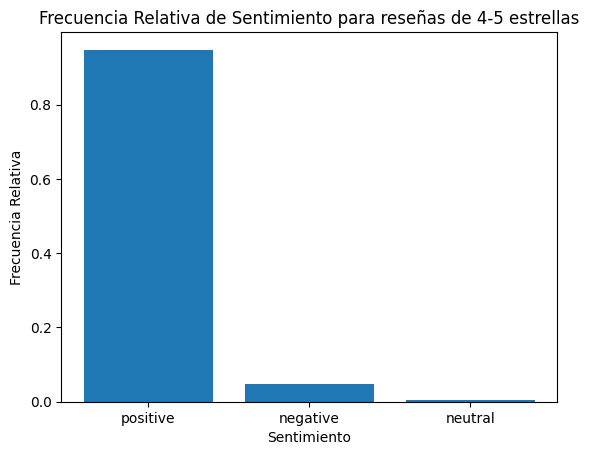

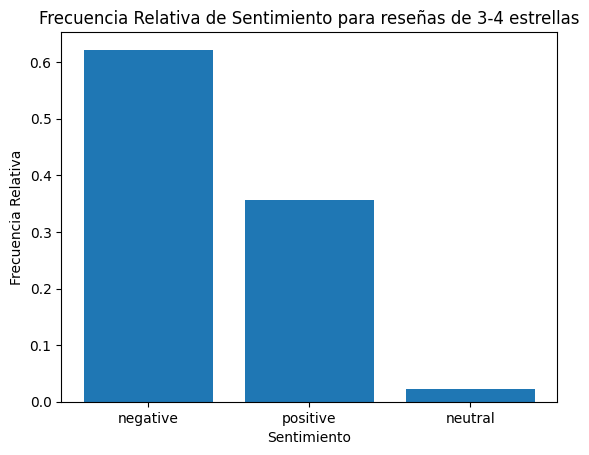

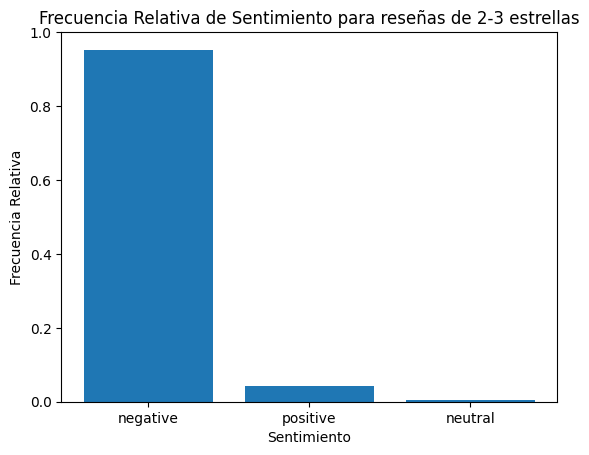

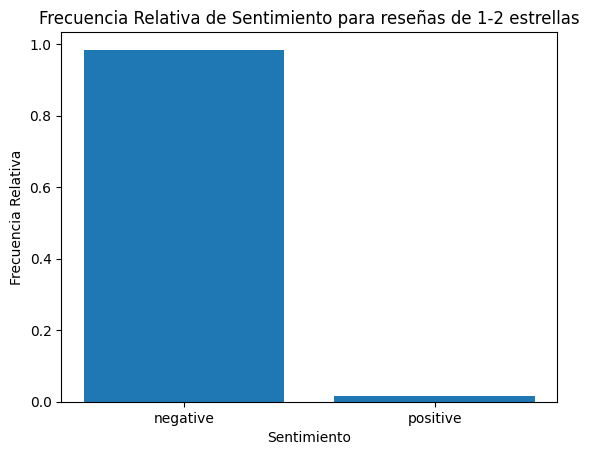

In [17]:
#Vamos a representar los resultados obtenidos gráficamente para que sea más visual:
#Importamos la biblioteca necesaria para graficar:
import matplotlib.pyplot as plt

# Definimos una función para generar los gráficos de frecuencia relativa:
def plot_sentimiento_frecuencia_relativa(data, titulo):
    sentimiento_counts = data['Sentimiento'].value_counts(normalize=True)
    plt.bar(sentimiento_counts.index, sentimiento_counts.values)
    plt.title(titulo)
    plt.xlabel('Sentimiento')
    plt.ylabel('Frecuencia Relativa')
    plt.show()

# Graficamos los gráficos que muestran las frecuencias relativas de sentimientos para cada rango de puntuaciones
plot_sentimiento_frecuencia_relativa(resultados_llamas_4_5, 'Frecuencia Relativa de Sentimiento para reseñas de 4-5 estrellas')
plot_sentimiento_frecuencia_relativa(resultados_llamas_3_4, 'Frecuencia Relativa de Sentimiento para reseñas de 3-4 estrellas')
plot_sentimiento_frecuencia_relativa(resultados_llamas_2_3, 'Frecuencia Relativa de Sentimiento para reseñas de 2-3 estrellas')
plot_sentimiento_frecuencia_relativa(resultados_llamas_1_2, 'Frecuencia Relativa de Sentimiento para reseñas de 1-2 estrellas')

Vemos que, en efecto, nuestra idea inicial sobre como clasificaba el modelo LLM era correcta. Las reseñas puntuadas en el rango 4-5 y en el rango 1-2 son clasificadas mayoritariamente como positivas y negativas respectivamente. Las reseñas entre 2-3 también son también mayoritariamente negativas, pero las reseñas entre 3-4 no son clasificadas en su mayoría como neutrales y positivas, sino como negativas, aunque la diferencia entre reseñas positivas y negativas no es tan abrupta como en el resto de casos. Esto pone de manifiesto que el modelo LLM no clasifica bien las reseñas neutrales, como se podía intuir en un principio.



In [18]:
#Por último, para los pasos posteriores, en los que llevaremos a cabo la construcción y entrenamiento de modelos de predicción, nos interesa que la
#variable 'Sentimiento' sea númerica:
data_LLM['Sentimiento'] = data_LLM['Sentimiento'].map({'positive': 1, 'neutral': 0, 'negative': -1})
data_LLM.head()

,Sentimiento,Rating,Reviews,Followers
0,1,5.0,1.0,2.0
1,1,5.0,3.0,2.0
2,1,5.0,2.0,3.0
3,1,5.0,1.0,1.0
4,1,5.0,3.0,2.0


In [19]:
#Guardamos los resultados obtenidos
from google.colab import files
nombre_archivo = "datos_procesados_llamas.csv"
data_LLM.to_csv(nombre_archivo, index=False, header=True,sep=';')
ubicacion_archivo = nombre_archivo
print("El archivo se ha guardado en:", ubicacion_archivo)

# Lo descargamos a nuestro ordenador
files.download(nombre_archivo)

El archivo se ha guardado en: datos_procesados_llamas.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>